# Librerías

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import json
import os
import random
import time

from urllib.request import Request, urlopen, urlretrieve
from typing import List
from pprint import pprint
from PIL import Image
from typing_extensions import Required
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM

# Extracción de datos con web scrapping


In [2]:
# son 905, pero los últimos no tienen data
max_pokemon: int = 898

In [3]:
types = ["grass", "fire", "water", "electric"]

In [4]:
dir1: str = "official-artwork"
if os.path.exists(dir1) == False:
    os.mkdir(dir1)

In [7]:
dir2: str = "all"
if os.path.exists(dir2) == False:
    os.mkdir(dir2)

In [ ]:
""" 
SOLO PARA DESCARGAR DATOS
"""
# for pokemon_id in range(max_pokemon):
#     req: Request = Request("https://pokeapi.co/api/v2/pokemon/"+str(pokemon_id+1), 
#                     headers={'User-Agent': 'Mozilla/5.0'})
#     webpage: bytes = urlopen(req).read()
#     json_obj: dict = json.loads(webpage)
#     img_url: str = json_obj["sprites"]["other"]["official-artwork"]["front_default"]
    
#     name: str = json_obj["species"]["name"]
#     type: str = json_obj["types"][0]["type"]["name"]

#     if os.path.exists(dir1+"/"+type) == False:
#         os.mkdir(dir1+"/"+type)
    
#     img: str = img_url.split("/")[-1]
#     urlretrieve(img_url, dir1+"/"+type+"/"+name+".png")

In [5]:
imgs_category: list = ["official-artwork", "home", "dream_world"]

In [8]:
for type in types:
    if os.path.exists(dir2+"/"+type) == False:
        os.mkdir(dir2+"/"+type)
    # if os.path.exists("svg/"+type) == False:
    #     os.mkdir("svg/"+type)

In [ ]:
""" 
SOLO PARA DESCARGAR DATOS
"""
# for pokemon_id in range(max_pokemon):
#     print(pokemon_id+1)
#     req: Request = Request("https://pokeapi.co/api/v2/pokemon/"+str(pokemon_id+1), 
#                     headers={'User-Agent': 'Mozilla/5.0'})
#     webpage: bytes = urlopen(req).read()
#     json_obj: dict = json.loads(webpage)
#     type: str = json_obj["types"][0]["type"]["name"]
#     if type not in types:
#         continue
#     name: str = json_obj["species"]["name"]

#     for img_category in imgs_category:
#         img_url: str = json_obj["sprites"]["other"][img_category]["front_default"]
#         if img_url == None:
#             continue
#         save_route: str = "/"+type+"/"+name+"_"+img_category+"."
#         format: str = img_url[-3:]
#         if format == "svg":
#             urlretrieve(img_url, "svg"+save_route+format)
#             drawing = svg2rlg("svg"+save_route+format)
#             renderPM.drawToFile(drawing, dir2+save_route+"png", fmt="PNG")
#         else:
#             urlretrieve(img_url, dir2+save_route+format)

In [9]:
# Distribución de los datos
for type in types:
    print(type, len(os.listdir(dir1+"/"+type)))
# types.remove("flying")
print(types)


grass 86
fire 58
water 123
electric 49
['grass', 'fire', 'water', 'electric']


In [10]:
# Distribución de los datos
sum: int = 0
for type in types:
    freq: int = len(os.listdir(dir2+"/"+type))
    sum += freq
    print(type, freq)
# types.remove("flying")
print(sum)

grass 233
fire 155
water 346
electric 131
865


# CNN

## Alexnet

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
for e in model.parameters():
   e.requires_grad = False
model.classifier[4] = nn.Linear(4096, 1024)
model.classifier[6] = nn.Linear(1024, len(types))
# model.classifier[6] = nn.Linear(4096, len(types))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

In [88]:
x: List[str] = []
y: List[str] = []
for type in types:
    pokemon_imgs: List[str] = os.listdir(dir1+"/"+type)
    for pokemon_img in pokemon_imgs:
        x.append(dir1+"/"+type+"/"+pokemon_img)
        y.append(type)

In [13]:
class MyDataset(Dataset):
      def __init__(self, list_IDs, labels):
            self.labels = labels
            self.list_IDs = list_IDs

      def __len__(self):
            return len(self.list_IDs)

      def __getitem__(self, index):
            # Select sample
            ID = self.list_IDs[index]

            # Load data and get label
            input_image = Image.open(ID)
            input_image = input_image.convert('RGB')
            preprocess = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.RandomHorizontalFlip(),
                  transforms.ToTensor()
            ])
            X = preprocess(input_image)
            y = self.labels[index]
            return X, y

In [105]:
le = preprocessing.LabelEncoder()
tensor_y = le.fit_transform(y)
tensor_y = torch.as_tensor(tensor_y)
dataset = MyDataset(x, tensor_y)


In [111]:
# bd_1
# data_train, data_val, data_test = random_split(dataset=dataset, lengths=[605, 87, 173])
# bd_2
data_train, data_val, data_test = random_split(dataset=dataset, lengths=[221, 32, 63])

In [112]:
batch_size = 32
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [113]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=0.005, momentum=0.9)
# optimizer = optim.SGD(model.parameters(), lr=0.005)
total_step = len(train_loader)
num_epochs = 100

In [22]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
def train(model, optimizer, loss_fn, num_epochs) -> List[float]:
  # train the model
  total_step: int = len(train_loader)
  # print(total_step)

  list_train_loss: List[float] = []
  list_val_loss: List[float] = []

  beg = time.time()
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # del images, labels, output
    
    train_loss: float = loss.item()
    list_train_loss.append(train_loss)
    with torch.no_grad():
        model.eval()
        for images, labels in val_loader:
          correct = 0
          total = 0
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = loss_fn(outputs, labels)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
              del images, labels, outputs

        val_loss: float = loss.detach().cpu()
        list_val_loss.append(val_loss)
        print ('Epoch [{}/{}], Train Loss: {:.4f}, Validation Loss {:.4f},  Accuracy: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, val_loss, 100*correct/total))
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return list_train_loss, list_val_loss

In [166]:
def test(model, save_name: str = ""):
    with torch.no_grad():
        all_predicted: list = []
        all_labels: list = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_predicted.extend((predicted).tolist())
            all_labels.extend((labels).tolist())
        # val = (np.unique(le.inverse_transform(all_predicted)))
        val = (np.unique(le.inverse_transform(all_labels)))
        matrix = confusion_matrix(all_labels, all_predicted)
        df = pd.DataFrame(matrix, index=val, columns=val)
        sns.heatmap(df, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        if save_name == "":
            plt.show()
        else:
            plt.savefig(PATH_RES+save_name)
        print('Test of the model on the {} test images'.format(len(data_test)))
        print('Acurracy: {:.2f} %'.format(100*accuracy_score(all_labels, all_predicted)))
        print('F1-score: {:.2f} %'.format(100*f1_score(all_labels, all_predicted, average='macro')))
        print('Recall: {:.2f} %'.format(100*recall_score(all_labels, all_predicted, average='macro')))
        print('Precision: {:.2f} %'.format(100*precision_score(all_labels, all_predicted, average='macro')))


In [114]:
train_loss, val_loss = train(model, optimizer, loss_fn, 30)

Epoch [1/30], Train Loss: 1.7068, Validation Loss 1.3674,  Accuracy: 28.1250
Epoch [2/30], Train Loss: 1.2724, Validation Loss 1.2958,  Accuracy: 40.6250
Epoch [3/30], Train Loss: 1.2381, Validation Loss 1.2538,  Accuracy: 40.6250
Epoch [4/30], Train Loss: 1.0710, Validation Loss 1.1751,  Accuracy: 40.6250
Epoch [5/30], Train Loss: 1.0020, Validation Loss 1.1410,  Accuracy: 56.2500
Epoch [6/30], Train Loss: 1.1765, Validation Loss 1.1011,  Accuracy: 59.3750
Epoch [7/30], Train Loss: 0.9427, Validation Loss 1.0606,  Accuracy: 50.0000
Epoch [8/30], Train Loss: 1.0138, Validation Loss 1.0225,  Accuracy: 56.2500
Epoch [9/30], Train Loss: 0.8632, Validation Loss 0.9909,  Accuracy: 65.6250
Epoch [10/30], Train Loss: 0.7945, Validation Loss 0.9804,  Accuracy: 65.6250
Epoch [11/30], Train Loss: 0.8203, Validation Loss 0.9743,  Accuracy: 56.2500
Epoch [12/30], Train Loss: 0.6568, Validation Loss 0.9472,  Accuracy: 56.2500
Epoch [13/30], Train Loss: 0.7853, Validation Loss 0.9107,  Accuracy: 65.

In [102]:
PATH_RES: str = "bd_2/"

Test of the model on the 63 test images
Acurracy: 77.78 %
F1-score: 74.38 %
Recall: 73.38 %
Precision: 76.77 %


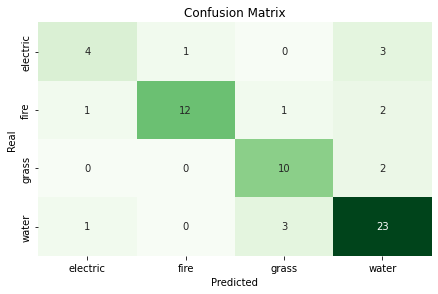

In [120]:
# test after train
torch.manual_seed(1)
test(model, "alexnet confusion matrix batch_size=32 SGD epochs=30 lr=1e-4 weight_decay=0.005 momentum=0.9.png")
# test(model, "alexnet confusion matrix batch_size=32 SGD epochs=100 lr=3e-4 weight_decay=0.005 momentum=0.9.png")
# test(model, "alexnet confusion matrix SGD epochs=100 lr=3e-4 weight_decay=0.005 momentum=0.9.png")
# test(model, "alexnet confusion matrix Adam epochs=100 lr=0.01.png")
# test(model, "alexnet confusion (sin modificar classifier alexnet) matrix SGD epochs=100 lr=3e-4 weight_decay=0.005 momentum=0.9.png")

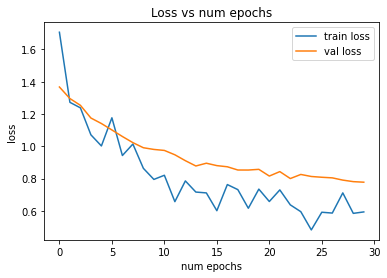

In [121]:
plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.ylabel("loss")
plt.xlabel("num epochs")
plt.title("Loss vs num epochs")
plt.legend()
plt.savefig(PATH_RES+"alexnet loss batch_size=32 SGD epochs=30 lr=1e-4 weight_decay=0.005 momentum=0.9.png")
# plt.savefig(PATH_RES+"alexnet loss SGD epochs=100 lr=3e-4 weight_decay=0.005 momentum=0.9.png")
# plt.savefig(PATH_RES+"alexnet loss Adam epochs=100 lr=0.01.png")
# plt.savefig(PATH_RES+"alexnet loss (sin modificar classifier alexnet) SGD epochs=100 lr=3e-4 weight_decay=0.005 momentum=0.9.png")
# plt.show()

## Resnet

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)
for e in resnet18.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18.fc = nn.Linear(in_features=512, out_features=len(types), bias=True)
optimizer = optim.SGD(resnet18.parameters(), lr=1e-4, weight_decay=0.005, momentum=0.9)
resnet18.to(device)

In [138]:
train_loss_resnet18, val_loss_resnet18 = train(resnet18, optimizer, loss_fn, 50)

Epoch [1/50], Train Loss: 1.5138, Validation Loss 1.4566,  Accuracy: 25.0000
Epoch [2/50], Train Loss: 1.3451, Validation Loss 1.3784,  Accuracy: 25.0000
Epoch [3/50], Train Loss: 1.3649, Validation Loss 1.3906,  Accuracy: 34.3750
Epoch [4/50], Train Loss: 1.5115, Validation Loss 1.4047,  Accuracy: 46.8750
Epoch [5/50], Train Loss: 1.3747, Validation Loss 1.4052,  Accuracy: 43.7500
Epoch [6/50], Train Loss: 1.4287, Validation Loss 1.3503,  Accuracy: 40.6250
Epoch [7/50], Train Loss: 1.3206, Validation Loss 1.3760,  Accuracy: 43.7500
Epoch [8/50], Train Loss: 1.3496, Validation Loss 1.3509,  Accuracy: 37.5000
Epoch [9/50], Train Loss: 1.1566, Validation Loss 1.3303,  Accuracy: 43.7500
Epoch [10/50], Train Loss: 1.2578, Validation Loss 1.3191,  Accuracy: 50.0000
Epoch [11/50], Train Loss: 1.3335, Validation Loss 1.3236,  Accuracy: 50.0000
Epoch [12/50], Train Loss: 1.2541, Validation Loss 1.2647,  Accuracy: 50.0000
Epoch [13/50], Train Loss: 1.2573, Validation Loss 1.2925,  Accuracy: 50.

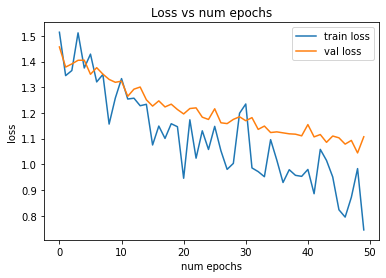

In [141]:
plt.plot(train_loss_resnet18, label="train loss")
plt.plot(val_loss_resnet18, label="val loss")
plt.ylabel("loss")
plt.xlabel("num epochs")
plt.title("Loss vs num epochs")
plt.legend()
# plt.show()
plt.savefig(PATH_RES+"resnet18 loss SGD epochs=50 lr=1e-4 weight_decay=0.005 momentum=0.9.png")

Test of the model on the 63 test images
Acurracy: 68.25 %
F1-score: 61.59 %
Recall: 61.52 %
Precision: 78.01 %


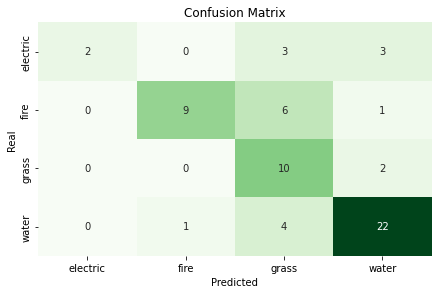

In [142]:
torch.manual_seed(1)
test(resnet18, "resnet18 confusion matrix SGD epochs=50 lr=1e-4 weight_decay=0.005 momentum=0.9.png")

In [ ]:
resnet34 = torchvision.models.resnet34(pretrained=True)
for e in resnet34.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet34.fc = nn.Linear(in_features=512, out_features=len(types), bias=True)
optimizer = optim.SGD(resnet34.parameters(), lr=1e-4, weight_decay=0.005, momentum=0.9)
resnet34.to(device)

In [147]:
train_loss_resnet34, val_loss_resnet34 = train(resnet34, optimizer, loss_fn, 50)

Epoch [1/50], Train Loss: 1.4980, Validation Loss 1.4260,  Accuracy: 31.2500
Epoch [2/50], Train Loss: 1.3990, Validation Loss 1.3517,  Accuracy: 25.0000
Epoch [3/50], Train Loss: 1.3897, Validation Loss 1.3288,  Accuracy: 28.1250
Epoch [4/50], Train Loss: 1.3056, Validation Loss 1.2915,  Accuracy: 40.6250
Epoch [5/50], Train Loss: 1.2216, Validation Loss 1.3071,  Accuracy: 34.3750
Epoch [6/50], Train Loss: 1.2748, Validation Loss 1.3086,  Accuracy: 37.5000
Epoch [7/50], Train Loss: 1.2645, Validation Loss 1.2781,  Accuracy: 40.6250
Epoch [8/50], Train Loss: 1.2209, Validation Loss 1.2447,  Accuracy: 40.6250
Epoch [9/50], Train Loss: 1.1298, Validation Loss 1.2503,  Accuracy: 40.6250
Epoch [10/50], Train Loss: 1.2933, Validation Loss 1.2006,  Accuracy: 50.0000
Epoch [11/50], Train Loss: 1.1555, Validation Loss 1.2412,  Accuracy: 46.8750
Epoch [12/50], Train Loss: 1.1642, Validation Loss 1.2088,  Accuracy: 50.0000
Epoch [13/50], Train Loss: 1.1680, Validation Loss 1.1969,  Accuracy: 46.

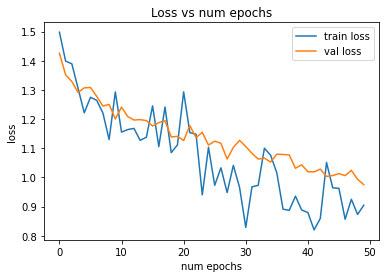

In [150]:
plt.plot(train_loss_resnet34, label="train loss")
plt.plot(val_loss_resnet34, label="val loss")
plt.ylabel("loss")
plt.xlabel("num epochs")
plt.title("Loss vs num epochs")
plt.legend()
plt.savefig(PATH_RES+"resnet34 loss SGD epochs=100 lr=1e-4 weight_decay=0.005 momentum=0.9.png")

Test of the model on the 63 test images
Acurracy: 61.90 %
F1-score: 53.50 %
Recall: 54.98 %
Precision: 65.04 %


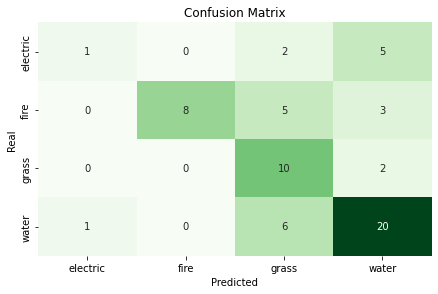

In [149]:
torch.manual_seed(1)
test(resnet34, "resnet34 confusion matrix SGD epochs=50 lr=1e-4 weight_decay=0.005 momentum=0.9.png")

## VGG

In [ ]:
vgg13 = torchvision.models.vgg13(pretrained=True)
for e in vgg13.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg13.classifier[3] = nn.Linear(in_features=4096, out_features=1024, bias=True)
vgg13.classifier[6] = nn.Linear(in_features=1024, out_features=len(types), bias=True)
optimizer = optim.SGD(vgg13.parameters(), lr=1e-4, weight_decay=0.005, momentum=0.9)
vgg13.to(device)

In [160]:
train_loss_vgg13, val_loss_vgg13 = train(vgg13, optimizer, loss_fn, 50)

Epoch [1/50], Train Loss: 1.3401, Validation Loss 1.3529,  Accuracy: 40.6250
Epoch [2/50], Train Loss: 1.3119, Validation Loss 1.3279,  Accuracy: 34.3750
Epoch [3/50], Train Loss: 1.3713, Validation Loss 1.2995,  Accuracy: 37.5000
Epoch [4/50], Train Loss: 1.2641, Validation Loss 1.3041,  Accuracy: 34.3750
Epoch [5/50], Train Loss: 1.1997, Validation Loss 1.2986,  Accuracy: 37.5000
Epoch [6/50], Train Loss: 1.2415, Validation Loss 1.2793,  Accuracy: 40.6250
Epoch [7/50], Train Loss: 1.3038, Validation Loss 1.2874,  Accuracy: 40.6250
Epoch [8/50], Train Loss: 1.3134, Validation Loss 1.2595,  Accuracy: 40.6250
Epoch [9/50], Train Loss: 1.2546, Validation Loss 1.2707,  Accuracy: 43.7500
Epoch [10/50], Train Loss: 1.1880, Validation Loss 1.2524,  Accuracy: 46.8750
Epoch [11/50], Train Loss: 1.2137, Validation Loss 1.2568,  Accuracy: 46.8750
Epoch [12/50], Train Loss: 1.1386, Validation Loss 1.2417,  Accuracy: 43.7500
Epoch [13/50], Train Loss: 1.1126, Validation Loss 1.2431,  Accuracy: 43.

In [ ]:
# test after train
torch.manual_seed(1)
test(vgg13, "vgg13 confusion matrix SGD epochs=50 lr=1e-4 weight_decay=0.005 momentum=0.9.png")

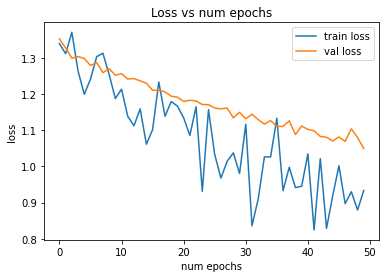

In [169]:
plt.plot(train_loss_vgg13, label="train loss")
plt.plot(val_loss_vgg13, label="val loss")
plt.ylabel("loss")
plt.xlabel("num epochs")
plt.title("Loss vs num epochs")
plt.legend()
plt.savefig(PATH_RES+"vgg13 loss SGD epochs=50 lr=1e-4 weight_decay=0.005 momentum=0.9.png")
# plt.show()